# **POS** tagger by using **Hidden Markov Models**

Members of the team:

1. Bukhari, Ibrahim

2. Kellich, Adam

3. Pramata, Nella Zabrina

4. Tagarro Melón, Pablo

Imp Note: *Dev dataset is used to verify the unknown tags in both emission and transition matrices. We will also have an additional category in the training dataset, which will have the UNK tag that contains unkown. The dev dataset will also be used for smoothing and more. We will categorize the most infrequent words into UNK.*

In [ ]:
#comment this line if not run in Colab
!pip install conllu

In [ ]:
#comment this cell if not run in Colab
from google.colab import drive

# Mounting Google Drive in Google Colab environment
# Mount Google Drive to the '/content/drive' directory
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Notes: don't forget to upload all the codes to the drive and adjust the path below according to your drive

In [ ]:
MYDRIVE_PATH = "/content/drive/MyDrive/"
# PROJECT_PATH = MYDRIVE_PATH + "/Master HAP LAP/LAP-CS /"
PROJECT_PATH = MYDRIVE_PATH + "/HMM/"

In [ ]:
# Importing all the libraries here
import os
from collections import defaultdict
import itertools
import conllu

# uncomment this if you run in local
#from hmm import HMM
from collections import Counter

In [ ]:
PROJECT_PATH + "hmm.py"

'/content/drive/MyDrive//HMM/hmm.py'

In [ ]:
#comment this cell if not run in Colab and uncomment the corresponding import above
%run "{PROJECT_PATH}hmm.py"

# Step 1: Converting Data into Tokens and Tags

## Initializing The Global Variables

- "dataset_paths" is a dictionary which has the language's names as its keys. It consists of a list that contains the file location of the traning, dev and testing datasets
- "parsed_datasets" is a dictionary which has the language's names as its keys. It consists if a list with all the datasets which have been parsed into sentences

- "tokenized_datasets" is a dictionary which has a list consisting of three further lists for training, dev and testing.
    - tokenized_datasets[ language ][ 0 ] = training dataset list of tuples, (tokens, tags)
    - tokenized_datasets[ language ][ 1 ] = dev dataset list of tuples, (tokens, tags)
    - tokenized_datasets[ language ][ 2 ] = testing dataset list of tuples, (tokens, tags)

In [ ]:
train_data_index = 0
dev_data_index = 1
test_data_index = 2

- "POS_dataset_tags" is a dictionary which stores all the tags within a language

In [ ]:

# Define the paths to the .conllu datasets
# use this cell if run in colab
dataset_paths = {
    'English': [PROJECT_PATH + 'English corpus/en_gum-ud-train.conllu', PROJECT_PATH + 'English corpus/en_gum-ud-dev.conllu', PROJECT_PATH + 'English corpus/en_gum-ud-test.conllu'],
    'Basque':  [PROJECT_PATH + 'Basque corpus/eu_bdt-ud-train.conllu', PROJECT_PATH + 'Basque corpus/eu_bdt-ud-dev.conllu', PROJECT_PATH + 'Basque corpus/eu_bdt-ud-test.conllu']
}

# use this cell if run in local
# dataset_paths = {
#     'English': ['Data/English/en_gum-ud-train.conllu', 'Data/English/en_gum-ud-dev.conllu', 'Data/English/en_gum-ud-test.conllu'],
#     'Basque':  ['Data/Basque/eu_bdt-ud-train.conllu', 'Data/Basque/eu_bdt-ud-dev.conllu', 'Data/Basque/eu_bdt-ud-test.conllu']
# }

# Initialize lists within a dictionary to store parsed data for each dataset
parsed_datasets = {
    'English': [],
    'Basque': []
}

# Initialize lists within a dictionary to store a tuple of (tokens, tags)
tokenized_datasets = {
    'English': [],
    'Basque': []
}

# Initialize lists within a dictionary to store a list of tags within each dataset
POS_dataset_tags = {
    'English': set(),
    'Basque': set()
}


## Parsing the Data Files

- In the following code we will parse the .conllu files and store all the three "Training, Dev and Testing" datasets of both languages into the "Paresed_datasets" variable.
- We will create a function "read_and_parse_conllu" which takes "file_path" as a parameter and returns conllu parsed class

In [ ]:
# Function to read and parse a .conllu file
def read_and_parse_conllu(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return conllu.parse(file.read())

In [ ]:
# Iterate through each language dataset
for language, data_paths in dataset_paths.items():
    print(f"\nLanguage: {language}\nData Paths:\n\t {data_paths}\n")

    for data_path in data_paths:
        parsed_data = read_and_parse_conllu(data_path)
        parsed_datasets[language].append(parsed_data)
        print(f"Parsed data for {language}: {data_path}")

    print(f"\nNumber of Sentence Datasets: {len(parsed_datasets[language])}\n")


Language: English
Data Paths:
	 ['/content/drive/MyDrive//HMM/English corpus/en_gum-ud-train.conllu', '/content/drive/MyDrive//HMM/English corpus/en_gum-ud-dev.conllu', '/content/drive/MyDrive//HMM/English corpus/en_gum-ud-test.conllu']

Parsed data for English: /content/drive/MyDrive//HMM/English corpus/en_gum-ud-train.conllu
Parsed data for English: /content/drive/MyDrive//HMM/English corpus/en_gum-ud-dev.conllu
Parsed data for English: /content/drive/MyDrive//HMM/English corpus/en_gum-ud-test.conllu

Number of Sentence Datasets: 3


Language: Basque
Data Paths:
	 ['/content/drive/MyDrive//HMM/Basque corpus/eu_bdt-ud-train.conllu', '/content/drive/MyDrive//HMM/Basque corpus/eu_bdt-ud-dev.conllu', '/content/drive/MyDrive//HMM/Basque corpus/eu_bdt-ud-test.conllu']

Parsed data for Basque: /content/drive/MyDrive//HMM/Basque corpus/eu_bdt-ud-train.conllu
Parsed data for Basque: /content/drive/MyDrive//HMM/Basque corpus/eu_bdt-ud-dev.conllu
Parsed data for Basque: /content/drive/MyDrive/

## Exploring the Parsed Datasets

Here we explore the basic information regrading the datasets which we have just parsed

In [ ]:
# Iterate through the languages and their corresponding datasets
for idx, language in enumerate(parsed_datasets.keys()):
    print(f"\nDataset of Language {idx + 1}: {language}")

    # Define dataset names
    dataset_names = ["training", "dev", "testing"]

    # Print the number of sentence datasets for each language
    print(f"Number of Sentence Datasets: {len(parsed_datasets[language])}")

    # Iterate through the sentence datasets for each language
    for idx, sentence_dataset in enumerate(parsed_datasets[language]):
        dataset_name = dataset_names[idx]

        # Print the number of sentences in each dataset for the current language
        print(f"{language} Sentences in the {dataset_name} Dataset: {len(sentence_dataset)}")


Dataset of Language 1: English
Number of Sentence Datasets: 3
English Sentences in the training Dataset: 8548
English Sentences in the dev Dataset: 1117
English Sentences in the testing Dataset: 1096

Dataset of Language 2: Basque
Number of Sentence Datasets: 3
Basque Sentences in the training Dataset: 5396
Basque Sentences in the dev Dataset: 1798
Basque Sentences in the testing Dataset: 1799


## Parsed Dataset into Token and Tags

Here we Extract the words(form) and POS(upos - universal part of speech) and store them within a tuple that is appended to our list.

In [ ]:
for language in parsed_datasets.keys():
    # English, Basque

    for sentence_dataset in parsed_datasets[language]:
        # 0 train, 1 dev, 2 test
        temp_tokenized_list = []

        for sentence in sentence_dataset:
            # Single Sentence form the one of the datasets from above
            temp_sentence_list = []

            for token in sentence:
                # single token from the sentence

                temp_sentence_list.append((token['form'], token['upos']))
                POS_dataset_tags[language].add(token['upos'])

            temp_tokenized_list.append(temp_sentence_list)

        tokenized_datasets[language].append(temp_tokenized_list)

## Exploring the Tokenized and Tagged Data

Here we explore the token size and all the Tags which are within a certain language. Furthemore we also see some examples of each dataset

In [ ]:
languages = ['English', 'Basque']

# Iterating through each language
for language in languages:
    for dataset_type, sentences in zip(['Train', 'Dev', 'Test'], tokenized_datasets[language]):
        print(f"{language} {dataset_type} Sentences: {len(sentences)}")
        print("Example:\n",*sentences[:2], sep='\n')
    print() # for better readability, no other purpose

# Printing the Part of Speech of both Languages
for language in languages:
    print(f"{language} POS Tags list: {POS_dataset_tags[language]}")


English Train Sentences: 8548
Example:

[('Aesthetic', 'ADJ'), ('Appreciation', 'NOUN'), ('and', 'CCONJ'), ('Spanish', 'ADJ'), ('Art', 'NOUN'), (':', 'PUNCT')]
[('Insights', 'NOUN'), ('from', 'ADP'), ('Eye', 'NOUN'), ('-', 'PUNCT'), ('Tracking', 'NOUN')]
English Dev Sentences: 1117
Example:

[('Introduction', 'NOUN')]
[('Research', 'NOUN'), ('on', 'ADP'), ('adult', 'NOUN'), ('-', 'PUNCT'), ('learned', 'VERB'), ('second', 'ADJ'), ('language', 'NOUN'), ('(', 'PUNCT'), ('L2', 'NOUN'), (')', 'PUNCT'), ('has', 'AUX'), ('provided', 'VERB'), ('considerable', 'ADJ'), ('insight', 'NOUN'), ('into', 'ADP'), ('the', 'DET'), ('neurocognitive', 'ADJ'), ('mechanisms', 'NOUN'), ('underlying', 'VERB'), ('the', 'DET'), ('learning', 'NOUN'), ('and', 'CCONJ'), ('processing', 'NOUN'), ('of', 'ADP'), ('L2', 'NOUN'), ('grammar', 'NOUN'), ('[', 'PUNCT'), ('1', 'NUM'), (']', 'PUNCT'), ('–', 'SYM'), ('[', 'PUNCT'), ('11', 'NUM'), (']', 'PUNCT'), ('.', 'PUNCT')]
English Test Sentences: 1096
Example:

[('The', 'D

In [ ]:
tokenized_datasets['English'][0]

[[('Aesthetic', 'ADJ'),
  ('Appreciation', 'NOUN'),
  ('and', 'CCONJ'),
  ('Spanish', 'ADJ'),
  ('Art', 'NOUN'),
  (':', 'PUNCT')],
 [('Insights', 'NOUN'),
  ('from', 'ADP'),
  ('Eye', 'NOUN'),
  ('-', 'PUNCT'),
  ('Tracking', 'NOUN')],
 [('Claire', 'PROPN'),
  ('Bailey', 'PROPN'),
  ('-', 'PUNCT'),
  ('Ross', 'PROPN'),
  ('claire.bailey-ross@port.ac.uk', 'PROPN'),
  ('University', 'PROPN'),
  ('of', 'ADP'),
  ('Portsmouth', 'PROPN'),
  (',', 'PUNCT'),
  ('United', 'VERB'),
  ('Kingdom', 'PROPN')],
 [('Andrew', 'PROPN'),
  ('Beresford', 'PROPN'),
  ('a.m.beresford@durham.ac.uk', 'PROPN'),
  ('Durham', 'PROPN'),
  ('University', 'PROPN'),
  (',', 'PUNCT'),
  ('United', 'VERB'),
  ('Kingdom', 'PROPN')],
 [('Daniel', 'PROPN'),
  ('Smith', 'PROPN'),
  ('daniel.smith2@durham.ac.uk', 'PROPN'),
  ('Durham', 'PROPN'),
  ('University', 'PROPN'),
  (',', 'PUNCT'),
  ('United', 'VERB'),
  ('Kingdom', 'PROPN')],
 [('Claire', 'PROPN'),
  ('Warwick', 'PROPN'),
  ('c.l.h.warwick@durham.ac.uk', 'PROPN

In [ ]:
# Training of HMM model

hmm_model = HMM()
hmm_model.train(tokenized_datasets['English'][0]) # default is use_log_prob=False


In [ ]:
print(hmm_model.get_emission_matrix().keys())
print(hmm_model.get_transition_matrix().keys())

dict_keys(['CCONJ', 'VERB', 'ADJ', 'PRON', '<STOP>', 'X', 'AUX', '_', 'UNK', 'PUNCT', 'PROPN', 'SYM', 'DET', 'INTJ', 'ADP', 'NOUN', 'SCONJ', '<START>', 'PART', 'NUM', 'ADV'])
dict_keys(['CCONJ', 'VERB', 'ADJ', 'PRON', '<STOP>', 'X', 'AUX', '_', 'UNK', 'PUNCT', 'PROPN', 'SYM', 'DET', 'INTJ', 'ADP', 'NOUN', 'SCONJ', '<START>', 'PART', 'NUM', 'ADV'])


In [ ]:
hmm_model.phi

{'CCONJ': 0.02905422778179731,
 'VERB': 0.09365638397742153,
 'ADJ': 0.058413408355706506,
 'PRON': 0.07236948319470937,
 '<STOP>': 0.05111845921106919,
 'X': 0.001817757819647331,
 'AUX': 0.04464867644508757,
 '_': 0.01312492899383517,
 'UNK': -inf,
 'PUNCT': 0.12330257894390663,
 'PROPN': 0.053821178074492194,
 'SYM': 0.0014111540968314807,
 'DET': 0.07221401706539743,
 'INTJ': 0.008078259257709027,
 'ADP': 0.08404738129264107,
 'NOUN': 0.14763900764773766,
 'SCONJ': 0.013800608709690921,
 'PART': 0.020778646129192353,
 'NUM': 0.017687261942489492,
 'ADV': 0.042017711179808535}

In [ ]:
tokenized_datasets['English'][0][0]

[('Aesthetic', 'ADJ'),
 ('Appreciation', 'NOUN'),
 ('and', 'CCONJ'),
 ('Spanish', 'ADJ'),
 ('Art', 'NOUN'),
 (':', 'PUNCT')]

In [ ]:
prediction = hmm_model.predict([
                                ["I",  "really", "like", "the", "movie."],\
                                ["I", "flew", "inside", "the", "ocean", "of", "wonders"], \
                                ["Aesthetic", "Appreciation", "and", "Spanish", "Art", ":"]
                                ])

# the last example is found in the data train tokenized_datasets['English'][0][0] and is predicted well
print(*prediction, sep='\n')


-- automatically select first possible tag: PROPN
-- automatically select first possible tag: X
-- automatically select first possible tag: PROPN
-- automatically select first possible tag: ADP
['PRON', 'ADV', 'ADP', 'DET', 'UNK']
['PRON', 'UNK', 'PROPN', 'X', 'PROPN', 'ADP', 'UNK']
['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']


# Step 2: Labeling the "UNK" tags in the dataset

# Filter dataset by giving words with low (n=5) frequency the UNK tag

CHECK THE NUMBER OF UNKS IN THE DATASET

In [ ]:
word_to_count_map = defaultdict(int)
for language in languages:
    train_data = tokenized_datasets[language][0]
    for sentence in train_data:
        for word, tag in sentence:
            word = word.lower().strip()
            word_to_count_map[word] += 1

LOW_FREQUENCY = 5
for language in languages:
  for idx in range(3):
    temp_data = tokenized_datasets[language][idx]

    for i, sentence in enumerate(temp_data):
        new_sentence = []
        for word, tag in sentence:
            word = word.lower().strip()
            if word_to_count_map[word] <= LOW_FREQUENCY:
                new_sentence.append((word, "UNK"))
            else:
                new_sentence.append((word, tag))
        tokenized_datasets[language][idx][i] = new_sentence  # Update the sentence in the original dataset

# Step 3: Use validation set to find the best hyperparameters
Training Function uses these hyperparams:
    - use_log_prob: bool = False
    - smoothing_factor: Optional[float] = None
    - apply_smoothing_in_emission_matrix: bool = False
    - apply_smoothing_in_transition_matrix: bool = False

In [ ]:
# Define the hyperparam grid
use_log_prob_options = [True, False]
smoothing_factor_options = [0.1, 0.5, 1, 1.5, 2]
# smoothing_factor_options = [1]
apply_smoothing_in_emission_matrix_options = [True, False]
apply_smoothing_in_transition_matrix_options = [True, False]

# Generate all possible combinations of hyperparameters
hyperparams_configurations = list(itertools.product(
    use_log_prob_options,
    smoothing_factor_options,
    apply_smoothing_in_emission_matrix_options,
    apply_smoothing_in_transition_matrix_options
))

# Find the best configuration
best_accuracy = {
    'English': 0,
    'Basque': 0
}
all_configs_and_accuracies = {
    'English': {},
    'Basque': {}
}
best_configuration = {
    'English': (),
    'Basque': ()
}

for language in languages:

    validation_data = tokenized_datasets[language][dev_data_index]
    train_data = tokenized_datasets[language][train_data_index]
    test_data = tokenized_datasets[language][test_data_index]

    for hpc in hyperparams_configurations:
        use_log_prob, smoothing_factor, apply_smoothing_emission, apply_smoothing_transition = hpc
        hmm_model = HMM()
        hmm_model.train(train_data,
                        use_log_prob=use_log_prob,
                        smoothing_factor=smoothing_factor,
                        apply_smoothing_in_emission_matrix=apply_smoothing_emission,
                        apply_smoothing_in_transition_matrix=apply_smoothing_transition)

        print("Exploring accuracy for: " + str(hpc))
        hpc_accuracy, hpc_pred_tags, hpc_orig_tags = hmm_model.accuracy(validation_data)
        all_configs_and_accuracies[language][(use_log_prob, smoothing_factor, apply_smoothing_emission, apply_smoothing_transition)] = \
            hpc_accuracy, hpc_pred_tags, hpc_orig_tags
        if hpc_accuracy > best_accuracy[language]:
            best_accuracy[language] = hpc_accuracy
            best_configuration[language] = hpc
            # print("Found new best config: ", best_configuration, hpc_accuracy)


print(f"Best config for English: ", best_configuration['English'], best_accuracy['English'])
print(f"Best config for Basque: ", best_configuration['Basque'], best_accuracy['Basque'])


Streaming output truncated to the last 5000 lines.
-- automatically select first possible tag: VERB
-- automatically select first possible tag: VERB
-- automatically select first possible tag: DET
-- automatically select first possible tag: VERB
-- automatically select first possible tag: VERB
-- automatically select first possible tag: CCONJ
-- automatically select first possible tag: ADP
-- automatically select first possible tag: VERB
-- automatically select first possible tag: CCONJ
-- automatically select first possible tag: ADJ
-- automatically select first possible tag: VERB
-- automatically select first possible tag: VERB
-- automatically select first possible tag: VERB
-- automatically select first possible tag: VERB
-- automatically select first possible tag: NOUN
-- automatically select first possible tag: VERB
-- automatically select first possible tag: ADP
-- automatically select first possible tag: VERB
-- automatically select first possible tag: ADP
-- automatically sele

## Analysis for the Hyperparameter

In [ ]:
import matplotlib.pyplot as plt

def plot_dictionary(dictionary):
  keys = dictionary.keys()
  values = dictionary.values()

  plt.plot(keys, values, linestyle='dashed')
  plt.xlabel('Keys')
  plt.ylabel('Values')
  plt.title('Dictionary Chart')
  plt.xticks(rotation=90)

  plt.show()

### English

In [69]:
hmm_model.train(tokenized_datasets['English'][train_data_index],
                use_log_prob=True,
                smoothing_factor=0.1,
                apply_smoothing_in_emission_matrix=True,
                apply_smoothing_in_transition_matrix=True)

hpc_accuracy, hpc_pred_tags, hpc_orig_tags = hmm_model.accuracy(tokenized_datasets['English'][dev_data_index])

In [70]:
orig_counter = Counter(hpc_orig_tags)
pred_counter = Counter(hpc_pred_tags)

In [71]:
orig_counter

Counter({'NOUN': 2028,
         'ADP': 1879,
         'PUNCT': 2605,
         'VERB': 1508,
         'ADJ': 888,
         'AUX': 1034,
         'UNK': 3277,
         'DET': 1598,
         'CCONJ': 651,
         'NUM': 256,
         'SYM': 14,
         'ADV': 833,
         'SCONJ': 321,
         'PRON': 1806,
         'PART': 510,
         'PROPN': 337,
         'X': 7,
         'INTJ': 178,
         '_': 234})

In [72]:
pred_counter

Counter({'NOUN': 2069,
         'ADP': 1938,
         'PUNCT': 2614,
         'VERB': 1419,
         'ADJ': 882,
         'AUX': 1149,
         'UNK': 3277,
         'DET': 1621,
         'CCONJ': 646,
         'NUM': 251,
         'ADV': 814,
         'PRON': 1812,
         'INTJ': 147,
         'PART': 521,
         'SCONJ': 263,
         'SYM': 9,
         'PROPN': 294,
         'X': 5,
         '_': 233})

In [73]:
print("Original Data with UNK Tag:", orig_counter["UNK"])
print("Predicted Data with UNK Tag:", pred_counter["UNK"])

print("Model Predict Known Word to UNK Tag approx. ~", pred_counter["UNK"] - orig_counter["UNK"])

Original Data with UNK Tag: 3277
Predicted Data with UNK Tag: 3277
Model Predict Known Word to UNK Tag approx. ~ 0


In [74]:
# check for if there is any bug in the HMM code sine it is an impossible case
# UNK tag should always be predicted as UNK, because the word should never be recognized by the model
for orig, pred in zip(hpc_orig_tags, hpc_pred_tags):
  if orig == "UNK" and pred != "UNK":
    print(orig, pred)

In [75]:
unknown_words = []
# check for the unknown words (not recognized by the model)
for idx in range(len(tokenized_datasets['English'][dev_data_index])):
  words = [w for w, _ in tokenized_datasets['English'][dev_data_index][idx]]
  tags = [t for _, t in tokenized_datasets['English'][dev_data_index][idx]]
  preds = hmm_model.predict([words])[0]
  w_idx = 0
  for y1, y2 in zip(tags, preds):
    if y1 != "UNK" and y2 == "UNK":
      print(f"sentence {idx} word '{words[w_idx]}':", y1, y2)
      unknown_words.append(words[w_idx])
    w_idx += 1

print("==============\n")
print(unknown_words)


[]


In [76]:
param_accuracy_pairs = {}
for key, value in all_configs_and_accuracies["English"].items():
  param_accuracy_pairs[str(key)] = value[0]

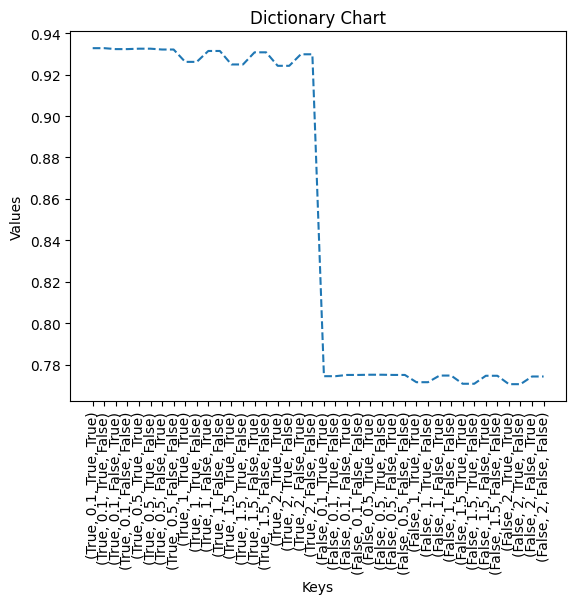

In [77]:
plot_dictionary(param_accuracy_pairs)

from the plot above, we can see that the 1st parameter `use_log_prob` is affecting the model when it set to True or False. This happen because if we don't use log, the value after the calculation of the decimals lead to really small numbers. If the small numbers are really small, the computer will be considered is as 0 (limitation of computer handling the underflow). With log, this can be avoided.

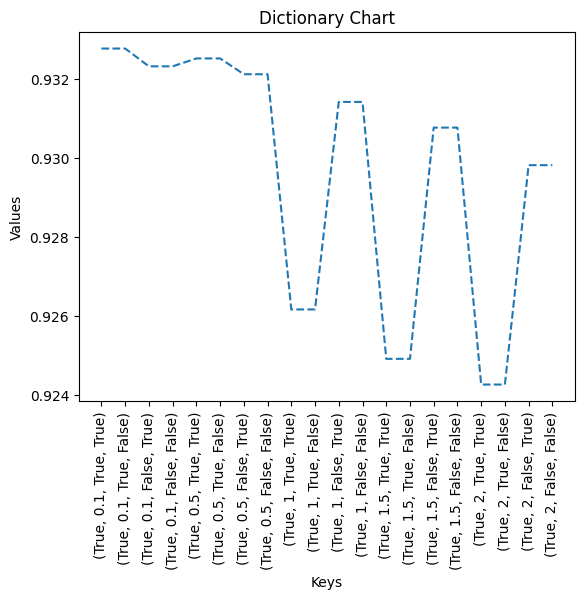

In [79]:
plot_dictionary(param_accuracy_pairs)

from the plot above, we can see that:
- the 2nd parameter `smoothing_factor`, the larger the value, the more the accuracy tends to decrease. This happens because if we give a lot smoothing, the unfrequent word will get a lot recognition than it has to (and may lead to incorrect prediction), which leads to low accuracy.
- the 3rd parameter `apply_smoothing_in_emission_matrix` (TO DO: WRITE THE REASON)
- the 4th parameter `apply_smoothing_in_transition_matrix` doesn't really affecting a lot since the total of tags are not that many as the emission_matrix.

In [78]:
param_accuracy_pairs = {}
for key, value in all_configs_and_accuracies["English"].items():
  if key[0] == True:
    param_accuracy_pairs[str(key)] = value[0]

In [80]:
words = []
for sent in tokenized_datasets['English'][train_data_index]:
  for w, _ in sent:
    words.append(w)

In [81]:
print(len(words))
print(len(Counter(words)))

150143
14822


### Basque

In [ ]:
hmm_model.train(tokenized_datasets['Basque'][train_data_index],
                use_log_prob=True,
                smoothing_factor=0.1,
                apply_smoothing_in_emission_matrix=True,
                apply_smoothing_in_transition_matrix=True)

hpc_accuracy, hpc_pred_tags, hpc_orig_tags = hmm_model.accuracy(tokenized_datasets['Basque'][dev_data_index])

In [ ]:
orig_counter = Counter(hpc_orig_tags)
pred_counter = Counter(hpc_pred_tags)

In [ ]:
orig_counter

Counter({'UNK': 8455,
         'CCONJ': 1196,
         'PUNCT': 3973,
         'DET': 685,
         'NUM': 428,
         'NOUN': 2254,
         'VERB': 2371,
         'AUX': 2263,
         'ADV': 779,
         'PRON': 108,
         'ADJ': 559,
         'PROPN': 383,
         'PART': 289,
         'X': 13,
         'INTJ': 1,
         'ADP': 338})

In [ ]:
pred_counter

Counter({'UNK': 8466,
         'CCONJ': 1196,
         'PUNCT': 3973,
         'DET': 706,
         'NUM': 435,
         'NOUN': 2238,
         'VERB': 2418,
         'AUX': 2223,
         'ADV': 778,
         'PRON': 106,
         'ADJ': 551,
         'PROPN': 368,
         'PART': 290,
         'X': 9,
         'ADP': 337,
         'SYM': 1})

In [ ]:
print("Original Data with UNK Tag:", orig_counter["UNK"])
print("Predicted Data with UNK Tag:", pred_counter["UNK"])

print("Model Predict Known Word to UNK Tag approx. ~", pred_counter["UNK"] - orig_counter["UNK"])

Original Data with UNK Tag: 8455
Predicted Data with UNK Tag: 8466
Model Predict Known Word to UNK Tag approx. ~ 11


In [ ]:
# check for if there is any bug in the HMM code sine it is an impossible case
# UNK tag should always be predicted as UNK, because the word should never be recognized by the model
for orig, pred in zip(hpc_orig_tags, hpc_pred_tags):
  if orig == "UNK" and pred != "UNK":
    print(orig, pred)

In [ ]:
unknown_words = []
# check for the unknown words (not recognized by the model)
for idx in range(len(tokenized_datasets['Basque'][dev_data_index])):
  words = [w for w, _ in tokenized_datasets['Basque'][dev_data_index][idx]]
  tags = [t for _, t in tokenized_datasets['Basque'][dev_data_index][idx]]
  preds = hmm_model.predict([words])[0]
  w_idx = 0
  for y1, y2 in zip(tags, preds):
    if y1 != "UNK" and y2 == "UNK":
      print(f"sentence {idx} word '{words[w_idx]}':", y1, y2)
      unknown_words.append(words[w_idx])
    w_idx += 1

print("==============\n")
print

sentence 699 word 'total': NOUN UNK
sentence 738 word 'force': PROPN UNK
sentence 748 word 'present': ADJ UNK
sentence 895 word 'pen': NOUN UNK
sentence 1245 word 'seven': PROPN UNK
sentence 1454 word 'pete': PROPN UNK
sentence 1635 word 'domain': PROPN UNK
sentence 1636 word 'coast': PROPN UNK
sentence 1649 word 'heat': PROPN UNK
sentence 1763 word 'rice': PROPN UNK
sentence 1770 word 'question': NOUN UNK

['total', 'force', 'present', 'pen', 'seven', 'pete', 'domain', 'coast', 'heat', 'rice', 'question']


In [ ]:
param_accuracy_pairs = {}
for key, value in all_configs_and_accuracies["Basque"].items():
  param_accuracy_pairs[str(key)] = value[0]

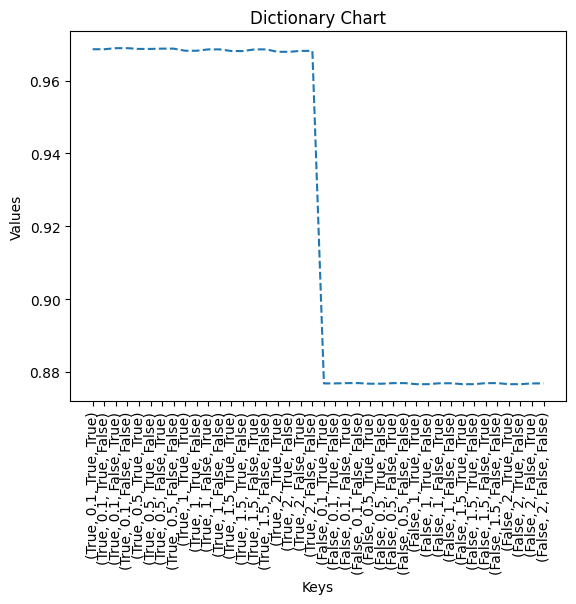

In [ ]:
plot_dictionary(param_accuracy_pairs)

from the plot above, we can see that the 1st parameter `use_log_prob` is affecting the model when it set to True or False. This happen because if we don't use log, the value after the calculation of the decimals lead to really small numbers. If the small numbers are really small, the computer will be considered is as 0 (limitation of computer handling the underflow). With log, this can be avoided.

In [ ]:
param_accuracy_pairs = {}
for key, value in all_configs_and_accuracies["Basque"].items():
  if key[0] == True:
    param_accuracy_pairs[str(key)] = value[0]

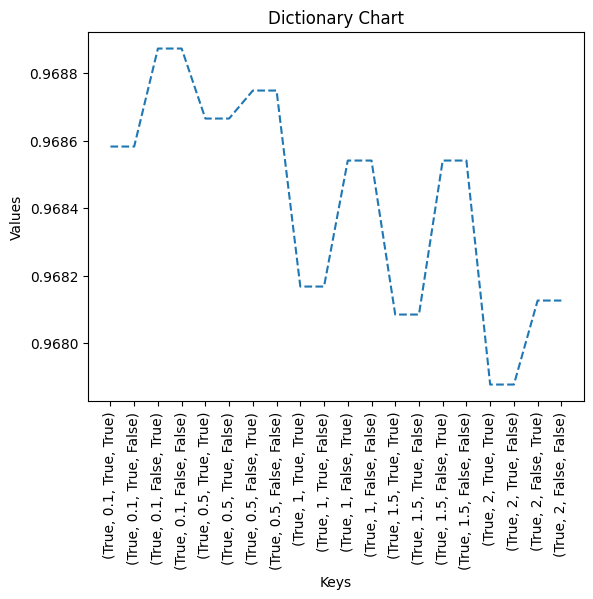

In [ ]:
plot_dictionary(param_accuracy_pairs)

from the plot above, we can see that:
- the 2nd parameter `smoothing_factor`, the larger the value, the more the accuracy tends to decrease. This happens because if we give a lot smoothing, the unfrequent word will get a lot recognition than it has to (and may lead to incorrect prediction), which leads to low accuracy.
- the 3rd parameter `apply_smoothing_in_emission_matrix` (TO DO: WRITE THE REASON)
- the 4th parameter `apply_smoothing_in_transition_matrix` doesn't really affecting a lot since the total of tags are not that many as the emission_matrix.

In [66]:
words = []
for sent in tokenized_datasets['Basque'][train_data_index]:
  for w, _ in sent:
    words.append(w)

In [68]:
print(len(words))
print(len(Counter(words)))

72974
17566


# Step 4: Evaluation of the model on test set


# Evaluation English dataset


In [82]:
#training dataset for English examples
train_english = tokenized_datasets['English'][0]

In [83]:
#test dataset for English examples
test_english = tokenized_datasets['English'][2]

In [84]:
#training of the model for English
hmm_model.train(train_english, use_log_prob=True, smoothing_factor=0.1, apply_smoothing_in_emission_matrix=True, \
                apply_smoothing_in_transition_matrix=True)

In [85]:
acc_english, pred_tags_english, orig_tags_english = hmm_model.accuracy(test_english)

In [86]:
print(f"Accuracy for English test set:", acc_english)

Accuracy for English test set: 0.9254375092955233


In [87]:
len(pred_tags_english) == len(orig_tags_english)

True

In [88]:
orig_tags = set()

for tag in orig_tags_english:
  orig_tags.add(tag)

orig_tags

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'UNK',
 'VERB',
 'X',
 '_'}

In [89]:
POS_dataset_tags['English']

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_'}

In [90]:
correct_tags = {'UNK': 0}
total_tags = {'UNK': 0}

for tag in POS_dataset_tags['English']:
    correct_tags[tag] = 0
    total_tags[tag] = 0

for idx, tag in enumerate(orig_tags_english):
  if tag == pred_tags_english[idx]:
    correct_tags[tag] += 1

  total_tags[tag] += 1

In [91]:
#Accuracy for adjectives in English

adj_acc = correct_tags['ADJ']/total_tags['ADJ']
print(adj_acc)

0.9372197309417041


In [92]:
#Accuracy for adpositions in English

adp_acc = correct_tags['ADP']/total_tags['ADP']
print(adp_acc)

0.917687408133268


In [93]:
#Accuracy for adverbs in English

adv_acc = correct_tags['ADV']/total_tags['ADV']
print(adv_acc)

0.8


In [94]:
#Accuracy for auxiliaries in English

aux_acc = correct_tags['AUX']/total_tags['AUX']
print(aux_acc)

0.9362162162162162


In [95]:
#Accuracy for coordinating conjunctions in English

cconj_acc = correct_tags['CCONJ']/total_tags['CCONJ']
print(cconj_acc)

0.9798561151079137


In [96]:
#Accuracy for determiners in English

det_acc = correct_tags['DET']/total_tags['DET']
print(det_acc)

0.9680418361417781


In [97]:
#Accuracy for interjections in English

intj_acc = correct_tags['INTJ']/total_tags['INTJ']
print(intj_acc)

0.6240601503759399


In [98]:
#Accuracy for nouns in English

nounacc = correct_tags['NOUN']/total_tags['NOUN']
print(nounacc)

0.9129098360655737


In [99]:
#Accuracy for numerals in English

num_acc = correct_tags['NUM']/total_tags['NUM']
print(num_acc)

0.9849056603773585


In [100]:
#Accuracy for particles in English

part_acc = correct_tags['PART']/total_tags['PART']
print(part_acc)

0.7793764988009593


In [101]:
#Accuracy for pronouns in English

pron_acc = correct_tags['PRON']/total_tags['PRON']
print(pron_acc)

0.9211444521981856


In [102]:
#Accuracy for proper nouns in English

propn_acc = correct_tags['PROPN']/total_tags['PROPN']
print(propn_acc)

0.6298157453936348


In [103]:
#Accuracy for punctuation marks in English

punct_acc = correct_tags['PUNCT']/total_tags['PUNCT']
print(punct_acc)

0.997244094488189


In [104]:
#Accuracy for subordinating conjunctions in English

sconj_acc = correct_tags['SCONJ']/total_tags['SCONJ']
print(sconj_acc)

0.532520325203252


In [105]:
#Accuracy for symbols in English

sym_acc = correct_tags['SYM']/total_tags['SYM']
print(sym_acc)

0.7142857142857143


In [106]:
#Accuracy for verbs in English

verb_acc = correct_tags['VERB']/total_tags['VERB']
print(verb_acc)

0.8540145985401459


In [107]:
#Accuracy for 'other' in English

x_acc = correct_tags['X']/total_tags['X']
print(x_acc)

0.36363636363636365


In [108]:
#Accuracy for unknown words in English

unk_acc = correct_tags['UNK']/total_tags['UNK']
print(unk_acc)

1.0


# Evaluation Basque dataset

In [109]:
#training dataset for Basque examples
train_basque = tokenized_datasets['Basque'][0]

In [110]:
#test dataset for Basque examples
test_basque = tokenized_datasets['Basque'][2]

In [111]:
#training of the model for Basque
hmm_model.train(train_basque, use_log_prob=True, smoothing_factor=0.1, \
                apply_smoothing_in_emission_matrix=False, apply_smoothing_in_transition_matrix=True)

In [112]:
acc_basque, pred_tags_basque, orig_tags_basque = hmm_model.accuracy(test_basque)

In [113]:
print(f"Accuracy for Basque test set:", acc_basque)

Accuracy for Basque test set: 0.9670140313448757


In [114]:
len(pred_tags_basque) == len(orig_tags_basque)

True

In [115]:
orig_tags = set()

for tag in orig_tags_basque:
  orig_tags.add(tag)

orig_tags

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'UNK',
 'VERB',
 'X'}

In [116]:
POS_dataset_tags['Basque']

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X'}

In [117]:
correct_tags_basque = {'UNK': 0}
total_tags_basque = {'UNK': 0}

for tag in POS_dataset_tags['Basque']:
    correct_tags_basque[tag] = 0
    total_tags_basque[tag] = 0

for idx, tag in enumerate(orig_tags_basque):
  if tag == pred_tags_basque[idx]:
    correct_tags_basque[tag] += 1

  total_tags_basque[tag] += 1

In [118]:
#Accuracy for adjectives in Basque

adj_acc_basque = correct_tags_basque['ADJ']/total_tags_basque['ADJ']
print(adj_acc_basque)

0.9542124542124543


In [119]:
#Accuracy for adpositions in Basque

adp_acc_basque = correct_tags_basque['ADP']/total_tags_basque['ADP']
print(adp_acc_basque)

0.9088471849865952


In [120]:
#Accuracy for adverbs in Basque

adv_acc_basque = correct_tags_basque['ADV']/total_tags_basque['ADV']
print(adv_acc_basque)

0.8894117647058823


In [121]:
#Accuracy for auxiliaries in Basque

aux_acc_basque = correct_tags_basque['AUX']/total_tags_basque['AUX']
print(aux_acc_basque)

0.9227353463587922


In [122]:
#Accuracy for coordinating conjunctions in Basque

cconj_acc_basque = correct_tags_basque['CCONJ']/total_tags_basque['CCONJ']
print(cconj_acc_basque)

0.9861563517915309


In [123]:
#Accuracy for determiners in Basque

det_acc_basque = correct_tags_basque['DET']/total_tags_basque['DET']
print(det_acc_basque)

0.9762900976290098


In [124]:
#Accuracy for interjections in Basque

intj_acc_basque = correct_tags_basque['INTJ']/total_tags_basque['INTJ']
print(intj_acc_basque)

0.0


In [125]:
#Accuracy for nouns in Basque

noun_acc_basque = correct_tags_basque['NOUN']/total_tags_basque['NOUN']
print(noun_acc_basque)

0.9358916478555305


In [126]:
#Accuracy for numerals in Basque

num_acc_basque = correct_tags_basque['NUM']/total_tags_basque['NUM']
print(num_acc_basque)

0.995475113122172


In [127]:
#Accuracy for particles in Basque

part_acc_basque = correct_tags_basque['PART']/total_tags_basque['PART']
print(part_acc_basque)

1.0


In [128]:
#Accuracy for pronouns in Basque

pron_acc_basque = correct_tags_basque['PRON']/total_tags_basque['PRON']
print(pron_acc_basque)

0.954954954954955


In [129]:
#Accuracy for proper nouns in Basque

propn_acc_basque = correct_tags_basque['PROPN']/total_tags_basque['PROPN']
print(propn_acc_basque)

0.9396984924623115


In [130]:
#Accuracy for punctuation marks in Basque

punct_acc_basque = correct_tags_basque['PUNCT']/total_tags_basque['PUNCT']
print(punct_acc_basque)

1.0


In [131]:
#Accuracy for subordinating conjunctions in Basque

sconj_acc_basque = correct_tags_basque['SCONJ']/(total_tags_basque['SCONJ'] + 0.01)
print(sconj_acc_basque)

0.0


In [132]:
#Accuracy for symbols in Basque

sym_acc_basque = correct_tags_basque['SYM']/(total_tags_basque['SYM'] + 0.01)
print(sym_acc_basque)

0.0


In [133]:
#Accuracy for verbs in Basque

verb_acc_basque = correct_tags_basque['VERB']/total_tags_basque['VERB']
print(verb_acc_basque)

0.892059553349876


In [134]:
#Accuracy for 'other' in Basque

x_acc_basque = correct_tags_basque['X']/total_tags_basque['X']
print(x_acc_basque)

0.65


In [135]:
#Accuracy for unkown words in Basque

unk_acc_basque = correct_tags_basque['UNK']/total_tags_basque['UNK']
print(unk_acc_basque)

1.0
